# Hints While Model Selecting

### Abstract:

We will create a classifier to try to identify handwritten digits 0-9 in the infamous [MNIST](https://en.wikipedia.org/wiki/MNIST_database) dataset. Each image is $28\text{px} \times 28\text{px}$, resulting in a total of $784$ pixels per image. We use the 60000 images+labels training set and 10000 images+labels test set which comes standard within the `keras` api through `tensorflow 2.0+`. 

### Objectives:

  - Create a few baseline models during EDA
  - Describe how observations in our baseline models might guide us towards a more sophisticated model
  - Choose between several model types after baseline based on application
  - Understand how to create persistence in models and Python objects

## Chapter 1: Requisite Loading

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
# import our own helper functions
from src.helpers import ravel_images, save_object, open_object

In [2]:
# Load the MNIST data
(Xtrain,ytrain), (Xtest,ytest) = mnist.load_data()

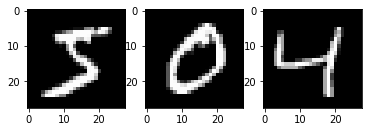

In [3]:
# Visualize a few 
fig, ax = plt.subplots(1,3)
ax[0].imshow(Xtrain[0], cmap = 'gray')
ax[1].imshow(Xtrain[1], cmap = 'gray')
ax[2].imshow(Xtrain[2], cmap = 'gray')
plt.show()

### Flattening for what follows

At this point, `Xtrain/Xtest` are 3-D arrays, where `Xtrain[i]` is the $28 \times 28$ array with the image. The general technique to coerce the feature tensor into a recognizable 2-D feature matrix is to ravel/flatten each image into a 784-long array into a row. This means that each pixel position in the images is considered its own feature. What will remain after the flattening of the images will be a training feature matrix of dimension $60000 \times 784$ and testing feature matrix of dimension $10000 \times 784$. 

In [4]:
# Flatten the image tensors into feature matrices
Xtrain, Xtest = ravel_images(Xtrain), ravel_images(Xtest)

In [5]:
print(f"Training shape: {Xtrain.shape} | Testing feature shape: {Xtest.shape}")

Training shape: (60000, 784) | Testing feature shape: (10000, 784)


## Chapter 2: Brainstorm Before Baselining

We will create data frames/series for `Xtrain` and `ytrain` to allow for some easy exploration.

In [6]:
Xtrain = pd.DataFrame(Xtrain, columns = [f"px{i}" for i in range(784)])
ytrain = pd.Series(ytrain, name = 'label')

# Get a look at the structuire
pd.concat((Xtrain,ytrain), axis = 1).head()

,px0,px1,px2,px3,px4,px5,px6,px7,px8,px9,...,px775,px776,px777,px778,px779,px780,px781,px782,px783,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9


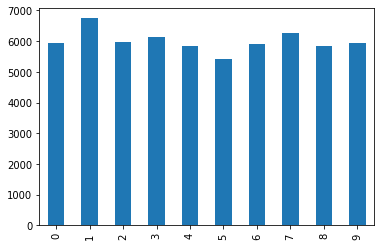

In [7]:
# Check for balance in our target
ytrain.value_counts().sort_index().plot(kind = 'bar')
plt.show()

There are 71 columns with no non-zero entry.


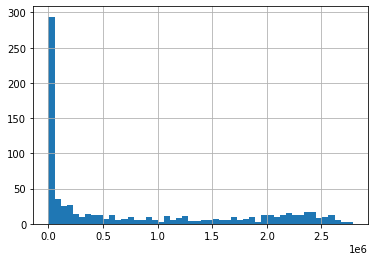

In [8]:
# Considering all the 0s we see, let's look at the variances
Xvar = (Xtrain ** 2).sum(axis = 0)
print(f"There are {(Xvar == 0).sum()} columns with no non-zero entry.")
Xvar.hist(bins = 50)
plt.show()

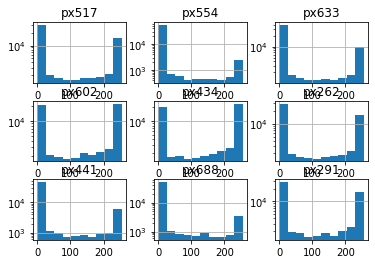

In [9]:
# We also consider what the distribution looks like
XhighVar = Xtrain.loc[:,Xvar > 0.5e6]
XhighVar.iloc[:,np.random.choice(range(XhighVar.shape[1]), 9)].hist(log = True)
plt.show()

### The brainstorming conversation

Our goal is to create a couple baseline classification models to compare before moving into finer tuning, in hopes to get some direction in that tuning. 

Let us first consider some possible models in our purposes:
- `LogisiticRegression`:
  - **Pro**: Easy to gauge how good/bad linear decision boundaries might work.
  - **Pro**: If linear decision boundaries might be a reasonable choice, we can easily gauge between bias/variance (via `C` in `sklearn`) to think about. 
  - **Con**: If linear decision boundaries are not a good choice, either we need to do much better feature engineering, or move to a non-linear model.
  - **Con**: With many features that aren't very interpretable from the start, injecting domain knowledge into feature engineering can be painful, and we will nonetheless likely need to reduce feature count. 
  
- `LinearDiscriminantAnalysis`:
  - **Pro**: Easy to gauge how good/bad linear decision boundaries might work.
  - **Pro**: Can perform similarly to LogisticRegression, but has more assumptions from its Bayesian classifier roots. 
  - **Pro**: We can reduce the feature space (via `n_components`) in a similar, but not exactly the same as PCA procedure that is intrinsict to LDA. 
  - **Con**: If linear decision boundaries are not a good choice, either we need to do much better feature engineering, or move to a non-linear model.
  - **Con**: With many features that aren't very interpretable from the start, injecting domain knowledge into feature engineering can be painful, and we will nonetheless likely need to reduce feature count. 
  - **Con**: Do we look Gaussian? 
  
- `QuadraticDiscriminantAnalysis`:
  - **Pro**: Can create a more complex decision boundary than the linear types whose shape in the feature space is somewhat recognizable.
  - **Con**: No bias/variance tradeoff nor many other tuning parameters to consider.
  - **Con**: Do we look Gaussian?
  
- `SVC`:
  - **Pro**: Can have non-linear boundaries with some variety. A good step if we want a low-dimensional polynomial boundary, for example. 
  - **Con**: Training can take a long time. 
  
- `RandomForestClassifier` or `GradientBoostingClassifier`: 
  - **Pro**: This is a powerful classifier which often works well "out of the box". 
  - **Pro**: As a tree based model, it works well with categorical columns, particularly of ordinal type. 
  - **Pro**: Many columns can help de-correlate trees to help more with mitigating high variance.
  - **Pro and Con**: While we can get a feel for how bad the overfitting is, it usually takes a fair amount of tuning to get a handle on it (`n_estimators`, `max_depth`, `ccp_alpha`, etc). 
  - **Con**: Random forest is still looking to be highly non-linear and is still possible to overfit. 
  - **Con**: Lose some ability to gauge where to aim with different models since we don't learn much about decision boundaries. 

What we will do: 

1. Very basic preprocessing by removing all columns that are constantly 0
2. Because we have a reasonably large dataset, we will downsample our training data by a factor of 10 and 5 so that our baseline classifiers train faster and to gauge how important adding more data into the training is to create a good classifier.
3. Train a `LogisticRegression` classifier (per downsample) with "out-of-the-box" performance, to probe how linear decision boundaries work and where we land in the bias/variance tradeoff.
4. Train a `QDA` classifier (per downsample) with "out-of-the-box" performance, to probe how the non-linear decision boundaries work and where we land compared to the logistic regression.
5. Based on previous two, make a few feature engineering adjustments if needed.

## Chapter 3: First Baseline Modeling

In [10]:
from sklearn.model_selection import cross_validate

### 3.1: Basic preprocessing

We've already done some preprocessing by flattening each image, now we remove the columns of all 0s.

In [11]:
class Remove0VarCols(object):
    
    def init(self):
        self.keep_cols = None
        self.been_fit = False
    
    def fit(self, X):
        self.keep_cols = ~((X**2).sum(axis = 0) == 0)
        self.been_fit = True
        return self
        
    def transform(self, X):
        if not self.been_fit:
            raise Exception("Need to fit on training before transforming.")
        return np.array(X)[:, self.keep_cols]

In [12]:
# Train on the training data!
rm0var = Remove0VarCols()
Xtrain_cl = rm0var.fit(Xtrain).transform(Xtrain)
Xtrain_cl.shape

(60000, 713)

In [13]:
# Note: once fit, can apply to Xtest without worry
rm0var.transform(Xtest).shape

(10000, 713)

### 3.2: Downsample

In [14]:
from sklearn.utils import resample

X10,y10 = resample(Xtrain_cl, ytrain, 
                   n_samples = Xtrain.shape[0]//10,
                   replace = False)
X5,y5 = resample(Xtrain_cl, ytrain,
                 n_samples = Xtrain.shape[0]//5,
                 replace = False)

### 3.3: Logistic Regression Baseline

In [15]:
from sklearn.linear_model import LogisticRegression

logr = LogisticRegression(max_iter = 2500)

In [16]:
logr_cv10_fp = 'output/logr_cv10.pk'
logr_cv5_fp = 'output/logr_cv5.pk'

In [17]:
# Baseline logistic regression on X10, y10
logr_cv10 = open_object(logr_cv10_fp)
if logr_cv10 is None:
    print("Recreating logr_cv10")
    logr_cv10 = cross_validate(logr, X10, y10, cv = 5, return_train_score = True)
print("Logistic Regression CV for 1/10 downsample loaded")

# Baseline logistic regression on X5, y5
logr_cv5 = open_object(logr_cv5_fp)
if logr_cv5 is None:
    print("Recreating logr_cv5")
    logr_cv5 = cross_validate(logr, X5, y5, cv = 5, return_train_score = True)
print("Logistic Regression CV for 1/5 downsample loaded")

Logistic Regression CV for 1/10 downsample loaded
Logistic Regression CV for 1/5 downsample loaded


In [18]:
# Persistence for logistic regression models
save_object(logr_cv10, logr_cv10_fp)
save_object(logr_cv5, logr_cv5_fp)

Filepath output/logr_cv10.pk already exists.
Rewrite anyway? ([y] or n): n
Filepath output/logr_cv5.pk already exists.
Rewrite anyway? ([y] or n): n


'output/logr_cv5.pk'

In [19]:
print(f"1/10 LogReg Train {logr_cv10['train_score'].mean()} | Test {logr_cv10['test_score'].mean()}")
print(f"1/5 LogReg Train {logr_cv5['train_score'].mean()} | Test {logr_cv5['test_score'].mean()}")

1/10 LogReg Train 1.0 | Test 0.8711666666666668
1/5 LogReg Train 1.0 | Test 0.8580833333333334


#### Lessons:

We learned that as is, logistic regression is overfitting and there weren't too many gains by adding in more data. We should then be able to check a range of `C` values which are smaller than $1$ and try again if we want to stick to linear decision boundaries. We should also consider LDA with decreasing number of components or perhaps using PCA before running logistic regression. 

### 3.4: QDA Baselines

In [20]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

qda = QDA()

In [21]:
qda_cv10_fp = 'output/qda_cv10.pk'
qda_cv5_fp = 'output/qda_cv5.pk'

In [22]:
# Baseline QDA on X10, y10
qda_cv10 = open_object(qda_cv10_fp)
if qda_cv10 is None:
    print("Recreating qda_cv10")
    qda_cv10 = cross_validate(qda, X10, y10, cv = 5, return_train_score = True)
print("QDA CV for 1/10 downsample loaded")

# Baseline QDA on X5, y5
qda_cv5 = open_object(qda_cv5_fp)
if qda_cv5 is None:
    print("Recreating qda_cv5")
    qda_cv5 = cross_validate(qda, X5, y5, cv = 5, return_train_score = True)
print("QDA CV for 1/5 downsample loaded")

QDA CV for 1/10 downsample loaded
QDA CV for 1/5 downsample loaded


In [23]:
# Persistence for QDA models
save_object(qda_cv10, qda_cv10_fp)
save_object(qda_cv5, qda_cv5_fp)

Filepath output/qda_cv10.pk already exists.
Rewrite anyway? ([y] or n): n
Filepath output/qda_cv5.pk already exists.
Rewrite anyway? ([y] or n): n


'output/qda_cv5.pk'

In [24]:
print(f"1/10 QDA Train {qda_cv10['train_score'].mean()} | Test {qda_cv10['test_score'].mean()}")
print(f"1/5 QDA Train {qda_cv5['train_score'].mean()} | Test {qda_cv5['test_score'].mean()}")

1/10 QDA Train 0.9964166666666665 | Test 0.5254999999999999
1/5 QDA Train 0.8408541666666668 | Test 0.6764999999999999


#### Lessons: 
Certainly we have trouble with multicollinearity, so someway to mitigate that would be ideal. We also see the overfitting like before. Note that we're note getting perfect train scores though -- this is likely do to the nature of assumptions over each class, we might have expected this to be bad (why?)! Also, we see an improvement with increasing the number of samples.

There is one lesson here though that is useful. If we have a more complicated, non-linear model, the quantity of data may help more than in the linear case. This might suggest to keep non-linear models in mind, but expect better performance at the large-quantity-of-data side of things.

### 3.4: Some adjustments

From our conversation above, I would like to try something else. I would like to try PCA to reduce feature space dimension before jumping into logistic regression. This might help us deal with the over-fitting. Again, we are doing this to probe, so we won't fine tune here too much. We will use the 1/5 downsample here as it provides more observations and might better resemble the full sample.

##### Exercise: 
Why and when might you choose probing PCA over varying `C` in LogisticRegression?

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# Preprocessing
ss = StandardScaler()
pca = PCA()
# Standardize and apply PCA
X5pca = pca.fit_transform(ss.fit_transform(X5))

ex_var = [0.8, 0.9, 0.95]

X5pca_cv_fp = 'output/X5pca_cv.pk'

X5pca_cv = open_object(X5pca_cv_fp)
if X5pca_cv is None:
    print("Recreating X5pca_cv")
    X5pca_cv = []
    for ev in ex_var:
        Xtemp = X5pca[:,pca.explained_variance_ratio_.cumsum() < ev]
        X5pca_cv.append((ev,cross_validate(logr, Xtemp, y5, 
                                           cv = 5, 
                                           return_train_score = True)))

save_object(X5pca_cv, X5pca_cv_fp)

Filepath output/X5pca_cv.pk already exists.
Rewrite anyway? ([y] or n): n


'output/X5pca_cv.pk'

In [26]:
# Investigate
X5pca_cv

[(0.8,
  {'fit_time': array([2.96354198, 2.983073  , 3.14295197, 2.69420576, 2.64024687]),
   'score_time': array([0.00208282, 0.00123596, 0.00103879, 0.00100994, 0.00102305]),
   'test_score': array([0.90208333, 0.90083333, 0.89416667, 0.89166667, 0.91      ]),
   'train_score': array([0.93645833, 0.93666667, 0.93635417, 0.9346875 , 0.93291667])}),
 (0.9,
  {'fit_time': array([4.29148388, 4.34254694, 4.45237923, 4.58346891, 4.47796917]),
   'score_time': array([0.00141311, 0.00133777, 0.00135183, 0.00134516, 0.00136089]),
   'test_score': array([0.89208333, 0.90041667, 0.89708333, 0.88916667, 0.9025    ]),
   'train_score': array([0.94989583, 0.94677083, 0.94729167, 0.9475    , 0.94614583])}),
 (0.95,
  {'fit_time': array([5.89850998, 5.59914994, 6.07005787, 4.97401381, 6.42305207]),
   'score_time': array([0.00217128, 0.00155115, 0.00159001, 0.00159383, 0.00180507]),
   'test_score': array([0.88125   , 0.89666667, 0.88291667, 0.88083333, 0.89208333]),
   'train_score': array([0.96104

#### Lesson:

This helped us a lot with overfitting. We also have a reasonable baseline accuracy performance metric to run off with. It seems we should expect at least a 90% accuracy if we now search deeper! Comparing our train and test scores, it seems that a PCA which keeps between 80%-90% of explained variance does quite well. 

## Chapter 4: Moving Up 

Finally, let's move back to full training data set with the following lessons in mind:

- It's easy to overfit -- even with linear decision boundaries -- without some feature engineering.
- Scaling and PCA at ~85% explained variance seems to help and create a reasonable model when used before LogisticRegression.
- Increasing the amount of data may improve our models performance if we move to slightly more-than-linear decision boundaries.

So, now that we have some perspective, my concluding attempt is the following hoping for a better baseline to then judge other probes into a more powerful classifier:

Use `SVC` to create a linear and low-D polynomial decision boundaries after scaling and applying PCA with 85% explained variance. (Again, this is just another trial, not complete fine tuning). 

In [27]:
# Here are the full preprocessing steps we want.

# Already done above, but let's not forget
rm0var = Remove0VarCols()
Xtrain_cl = rm0var.fit(Xtrain).transform(Xtrain)

# Standardize and PCA
ss = StandardScaler()
pca = PCA(n_components=0.85)
Xtrain_cl = ss.fit_transform(Xtrain_cl)
Xtrain_cl = pca.fit_transform(Xtrain_cl)

# Reproduce for test and beyond!
def preprocess(X):
    retX = rm0var.transform(X)
    retX = ss.transform(retX)
    return pca.transform(retX)

In [33]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, KFold

# Create SVC instance
svc = SVC()

# Set up grid search params
kf5 = KFold(n_splits = 5, shuffle = True)
svc_params = {'kernel':['poly'], 'degree':[1,2]}

# Output file for persistence
svc_cv_fp = 'output/svc_cv.pk'

# If this grid search has been created, use it!
svc_cv = open_object(svc_cv_fp)

# If not, let's do it!
if svc_cv is None:
    print("Recreating svc_cv")
    svc_cv = GridSearchCV(estimator=svc, 
                          param_grid=svc_params,
                          return_train_score=True,
                          cv = kf5,
                          refit = True)
    svc_cv.fit(Xtrain_cl, ytrain)
    
# Save the grid search if not already saved
save_object(svc_cv, svc_cv_fp)

Error [Errno 2] No such file or directory: 'output/svc_cv.pk' occurred while trying to open pickle file output/svc_cv.pk.
Recreating svc_cv


'output/svc_cv.pk'

In [34]:
# Investigate
print(f"With the parameters {svc_cv.best_params_}:")
print(f"\t- Best CV score: {svc_cv.best_score_}")

With the parameters {'degree': 2, 'kernel': 'poly'}:
	- Best CV score: 0.9713499999999999
